In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
sns.set()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import defaultdict
from fuzzywuzzy import fuzz
import string
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Explore the data

In [9]:
df_train = pd.read_csv('data/train_data.csv').fillna('')
labels = pd.read_csv('data/train_labels.csv').fillna('')
df_test = pd.read_csv('data/test_data.csv').fillna('')

In [10]:
df_train.head(25)

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,
5,5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",
6,6,Should I buy tiago?,What keeps childern active and far from phone ...,
7,7,How can I be a good geologist?,What should I do to be a great geologist?,
8,8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",
9,9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323164 entries, 0 to 323163
Data columns (total 4 columns):
id              323164 non-null int64
question1       323164 non-null object
question2       323164 non-null object
is_duplicate    323164 non-null object
dtypes: int64(1), object(3)
memory usage: 9.9+ MB


In [14]:
df_test.head()

,test_id,question1,question2
0,15,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...
1,20,Why do rockets look white?,Why are rockets and boosters painted white?
2,21,What's causing someone to be jealous?,What can I do to avoid being jealous of someone?
3,23,How much is 30 kV in HP?,Where can I find a conversion chart for CC to ...
4,34,What is the best travel website in spain?,What is the best travel website?


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81126 entries, 0 to 81125
Data columns (total 3 columns):
test_id      81126 non-null int64
question1    81126 non-null object
question2    81126 non-null object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [15]:
labels.head()

,id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [12]:
df_train.shape

(323164, 4)

In [16]:
labels.shape

(323164, 2)

In [17]:
df_train['is_duplicate'] = labels['is_duplicate']

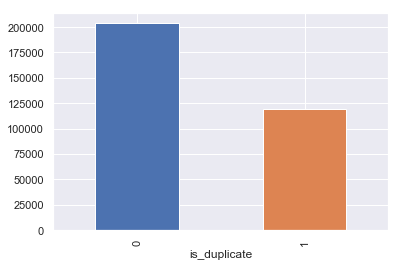

In [19]:
df_train.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
def preprocess(df):
    """
    Cleaning and preprocessing for the questions,
    returns data frame with new processed columns
    """
    
    # remove unicode accents with ascii
    df['question1'] = df['question1'].apply(
        lambda s: unidecode.unidecode(str(s)))
    df['question2'] = df['question2'].apply(
        lambda s: unidecode.unidecode(str(s)))
    
#     # lowercase all words
#     df['question1_processed'] = df['question1_processed'].str.lower()
#     df['question2_processed'] = df['question2_processed'].str.lower()
    
    # replace some stuff with regex
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"what's", "what is", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"\'s", "", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"\'ve", " have ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"can't", "cannot", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"n't", " not ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"\'m ", " am ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"\'re", " are ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"\'d", " would ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"\'ll", " will ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" e g ", " eg ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" 9 11 ", "911", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"e-mail", "email", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" usa ", " America ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" USA ", " America ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" u s ", " America ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" US ", " America ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" uk ", " England ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" UK ", " England ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" Uk ", " England ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" kms ", " kilometers ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" Kms ", " kilometers ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" km ", " kilometers ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" KM ", " kilometers ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" Km ", " kilometers ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" KMs ", " kilometers ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" cs ", " computer science ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" CS ", " computer science ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"calender", "calendar", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"quora", "Quora", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"india", "India", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"switzerland", "Switzerland", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"china", "China", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"programing", "programming", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r"bestfriend", "best friend", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" iii ", " 3 ", s))
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r" ii ", " 2 ", s))
    
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"what's", "what is", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"\'s", "", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"\'ve", " have ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"can't", "cannot", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"n't", " not ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"\'m ", " am ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"\'re", " are ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"\'d", " would ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"\'ll", " will ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" e g ", " eg ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" 9 11 ", "911", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"e-mail", "email", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" usa ", " America ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" USA ", " America ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" u s ", " America ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" US ", " America ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" uk ", " England ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" UK ", " England ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" Uk ", " England ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" kms ", " kilometers ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" Kms ", " kilometers ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" km ", " kilometers ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" KM ", " kilometers ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" Km ", " kilometers ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" KMs ", " kilometers ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" cs ", " computer science ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" CS ", " computer science ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"calender", "calendar", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"quora", "Quora", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"india", "India", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"switzerland", "Switzerland", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"china", "China", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"programing", "programming", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r"bestfriend", "best friend", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" iii ", " 3 ", s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r" ii ", " 2 ", s))
     
    # remove parts inside html tags for math
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r'\[math.+\[/math\]','',s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r'\[math.+\[/math\]','',s))
        
    # remove only punctuation
    df['question1'] = df['question1'].apply(
        lambda s: re.sub(r'[^\w\s]','',s))
    df['question2'] = df['question2'].apply(
        lambda s: re.sub(r'[^\w\s]','',s))
        
    # remove all non-alphanumeric characters
#     df['question1'] = df['question1'].apply(
#         lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))
#     df['question2'] = df['question2'].apply(
#         lambda s: re.sub(r'[^A-Za-z0-9 ]', '', s))
    
    # remove stop words
#     df['question1'] = df['question1'].apply(
#         lambda s: ' '.join(word for word in s.split() if word not in stop_words))
#     df['question2'] = df['question2'].apply(
#         lambda s: ' '.join(word for word in s.split() if word not in stop_words))
    
    return df

In [18]:
%%time
df_train = preprocess(df_train)
df_test = preprocess(df_test)

CPU times: user 37.3 s, sys: 175 ms, total: 37.4 s
Wall time: 37.5 s


# Feature engineering

In [5]:
# common unigrams count

eng_stopwords = set(stopwords.words('english'))


def get_unigrams(question):
    return [word for word in word_tokenize(question.lower())
            if word not in eng_stopwords]

def get_common_unigrams(row):
    return len(set(row['unigrams_q1']).intersection(set(row['unigrams_q2'])))


def get_common_unigram_ratio(row):
    return float(row['unigrams_common_count']) / max(
        len(set(row['unigrams_q1']).union(set(row['unigrams_q2']))), 1)

In [6]:
def create_q_dict(questions):
    q_dict = defaultdict(set)
    for i in range(questions.shape[0]):
        q_dict[questions.question1[i]].add(questions.question2[i])
        q_dict[questions.question2[i]].add(questions.question1[i])
    return q_dict

In [7]:
questions = pd.concat(
    [df_train[['question1', 'question2']], df_test[['question1', 'question2']]],
    axis=0).reset_index(drop='index')

q_dict = create_q_dict(questions)

In [8]:
# Frequency based features

def q1_freq(row):
    return (len(q_dict[row['question1']]))

def q2_freq(row):
    return (len(q_dict[row['question2']]))

# Q1-Q2 intersection of common neighbours
def q1_q2_intersect(row):
    return (len(
        set(q_dict[row['question1']]).intersection(
            set(q_dict[row['question2']]))))

In [40]:
# NLP features


def find_common_words(set1, set2):
    porter = nltk.PorterStemmer()
    common = set1.intersection(set2)
    unmatched_words_set1 = set1.difference(set2)
    unmatched_words_set2 = set2.difference(set1)
    stemmed_key1 = [porter.stem(t) for t in unmatched_words_set1]
    stemmed_key2 = [porter.stem(t) for t in unmatched_words_set2]
    stemmed_set = set([w for w in stemmed_key1 if w in stemmed_key2])
    common = common.union(stemmed_set)
    return common


def extract_words(row, q_num):
    translator = str.maketrans('', '', string.punctuation)
    question = str(row[q_num]).translate(translator)
    question_words = question.split()
    return question_words


def extract_verbs(row, q_num):
    tagged_sent = nltk.pos_tag(extract_words(row, q_num))
    vb = set([word.lower() for word, pos in tagged_sent if pos[:2] == 'VB'])
    return vb


def extract_bigrams(row, q_num):
    bigrams = nltk.bigrams(extract_words(row, q_num))
    return bigrams


def extract_noun_phrases(row, q_num):
    np_list = []
    grammar = "NP: {<DT|PP\$>?<JJ.*>*<NN.*>+}"
    cp = nltk.RegexpParser(grammar)
    tagged_sent = nltk.pos_tag(extract_words(row, q_num))
    tree = cp.parse(tagged_sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            np_list.extend([word for (word, pos) in subtree])
    np_set = set([word.lower() for word in np_list])
    return np_set


def find_common_verbs(row):
    vb1 = extract_verbs(row, 'question1')
    vb2 = extract_verbs(row, 'question2')
    c_verbs = find_common_words(vb1, vb2)
    return len(c_verbs)


def all_common_words_ratio(row):
    question1_lower = set(
        [word.lower() for word in extract_words(row, 'question1')])
    question2_lower = set(
        [word.lower() for word in extract_words(row, 'question2')])
    c_words = find_common_words(question1_lower, question2_lower)
    ratio = len(c_words) / max((len(question1_lower), len(question2_lower)))
    return ratio


def find_common_bigrams_ratio(row):
    ques1_bigrams = extract_bigrams(row, 'question1')
    ques2_bigrams = extract_bigrams(row, 'question2')
    c_bigrams = [(a, b) for (a, b) in ques1_bigrams if (a, b) in ques2_bigrams]
    ratio = len(c_bigrams) / max(ques1_bigrams.__sizeof__(),
                                 ques2_bigrams.__sizeof__())
    return ratio


def find_common_noun_phases_ratio(row):
    ques1_np_set = extract_noun_phrases(row, 'question1')
    ques2_np_set = extract_noun_phrases(row, 'question2')
    c_np = find_common_words(ques1_np_set, ques2_np_set)
    if (len(ques1_np_set) == 0 and len(ques2_np_set) == 0):
        np_ratio = 0
    else:
        np_ratio = len(c_np) / max((len(ques1_np_set), len(ques2_np_set)))
    return np_ratio

In [9]:
#Adding common words, words and bigrams
def add_common(df):
    common_words = []
    common_verbs = []
    common_bigrams = []
    common_np = []
    for index,row in df.iterrows() :
        common_words.append(all_common_words_ratio(row))
        common_verbs.append(find_common_verbs(row))
        common_bigrams.append(find_common_bigrams_ratio(row))
        common_np.append(find_common_noun_phases_ratio(row))
    df['common_verbs'] = common_verbs
    df['common_words'] = common_words
    df['common_bigrams'] = common_bigrams
    df['common_np'] = common_np

In [10]:
# Word count for how, what, which, who, where, when, why


def add_word_count(x, df, word):
    df['q1_' +
       word] = df['question1'].apply(lambda x: (word in str(x).lower()) * 1)
    df['q2_' +
       word] = df['question2'].apply(lambda x: (word in str(x).lower()) * 1)
    df[word + '_both'] = df['q1_' + word] * df['q2_' + word]

In [11]:
def count_question_words(df):
    words = ['how', 'what', 'which', 'who', 'where', 'when', 'why']
    for w in words:
        add_word_count(df, df, w)

In [32]:
def generate_features(df):
    """
    Generates features for the input dataframe,
    returns the modified dataframe with new columns
    """
    
    # number of words in a question
    df['words_count_q1'] = df['question1_processed'].str.split().str.len()
    df['words_count_q2'] = df['question2_processed'].str.split().str.len()
    
    # difference between the number of words in two questions
    df['diff_words_count'] = abs(df.words_count_q1 - df.words_count_q2)
    
    # number of characters in a question
    # removing all non-alphanumeric characters and spaces
    df['char_count_q1'] = df['question1_processed'].apply(
        lambda s: len(re.sub(r'[^A-Za-z0-9]', '', s)))
    df['char_count_q2'] = df['question2_processed'].apply(
        lambda s: len(re.sub(r'[^A-Za-z0-9]', '', s)))
    
    # average word length
    df['avg_word_len_q1'] = df.char_count_q1 / df.words_count_q1
    df['avg_word_len_q2'] = df.char_count_q2 / df.words_count_q2
    df['diff_avg_word_len'] = abs(df.avg_word_len_q1 - df.avg_word_len_q2)
    
    # number of common words
    df['common_words_count'] = df.apply(
        lambda x: len(set(str(x['question1_processed']).split()).intersection(
            set(str(x['question2_processed']).split()))), axis=1)

    # calculate fuzzywuzzy metrics
    df['fuzzy_qratio'] = df.apply(lambda x: fuzz.QRatio(
        str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    df['fuzzy_wratio'] = df.apply(lambda x: fuzz.WRatio(
        str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    df['fuzzy_partial_ratio'] = df.apply(lambda x:fuzz.partial_ratio(
        str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    df['fuzzy_partial_token_set_ratio'] = df.apply(
        lambda x:fuzz.partial_token_set_ratio(
            str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    df['fuzzy_partial_token_sort_ratio'] = df.apply(
        lambda x:fuzz.partial_token_sort_ratio(
            str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    df['fuzzy_token_sort_ratio'] = df.apply(
        lambda x:fuzz.token_sort_ratio(
            str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    df['fuzzy_token_set_ratio'] = df.apply(
        lambda x:fuzz.token_set_ratio(
            str(x['question1_processed']), str(x['question2_processed'])), axis=1)
    
    return df

In [12]:
%%time
df_train = generate_features(df_train)
df_test = generate_features(df_test)

CPU times: user 3min 4s, sys: 1.32 s, total: 3min 5s
Wall time: 3min 3s


In [36]:
# TFIDF features for both question1 and question2

tfv = TfidfVectorizer(
    min_df=3,
    max_features=None,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'w{1,}',
    ngram_range=(1, 2),
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    stop_words='english')

q1_tfidf_train = tfv.fit_transform(df_train.question1.fillna(''))
q2_tfidf_train = tfv.fit_transform(df_train.question2.fillna(''))

q1_tfidf_test = tfv.fit_transform(df_test.question1.fillna(''))
q2_tfidf_test = tfv.fit_transform(df_test.question2.fillna(''))

In [39]:
# SVD (singular value decomposition) features

svd = TruncatedSVD()

question1_vectors_train = svd.fit_transform(q1_tfidf_train)
question2_vectors_train = svd.fit_transform(q2_tfidf_train)

question1_vectors_test = svd.fit_transform(q1_tfidf_test)
question2_vectors_test = svd.fit_transform(q2_tfidf_test)

In [41]:
# Obtaining features by stacking the matrices together

vec_stack_train = np.hstack((question1_vectors_train, question2_vectors_train))
vec_stack_test = np.hstack((question1_vectors_test, question2_vectors_test))

In [13]:
df_train.tail(10)

,id,question1,question2,is_duplicate,question1_processed,question2_processed,words_count_q1,words_count_q2,diff_words_count,char_count_q1,...,avg_word_len_q2,diff_avg_word_len,common_words_count,fuzzy_qratio,fuzzy_wratio,fuzzy_partial_ratio,fuzzy_partial_token_set_ratio,fuzzy_partial_token_sort_ratio,fuzzy_token_sort_ratio,fuzzy_token_set_ratio
323154,404280,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1,outfit ideas wear frat party,outfit ideas wear frat themed party,5,6,1,24,...,5.000000,0.200000,5,89,95,86,100,89,89,100
323155,404281,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1,manaphy childish pokemon ranger temple sea,manaphy annoying pokemon ranger temple sea,6,6,0,37,...,6.166667,0.000000,5,83,84,83,100,83,83,88
323156,404282,How does a long distance relationship work?,How are long distance relationships maintained?,1,long distance relationship work,long distance relationships maintained,4,4,0,28,...,8.750000,1.750000,2,78,78,87,100,65,75,75
323157,404283,What do you think of the removal of the MagSaf...,What will the CPU upgrade to the 2016 Apple Ma...,0,think removal magsafe connector apple macbook pro,cpu upgrade apple macbook pro mean,7,6,1,43,...,4.833333,1.309524,3,53,64,63,100,62,60,67
323158,404284,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1,jainism say homosexuality,jainism say gays homosexuality,3,4,1,23,...,6.750000,0.916667,3,91,95,80,100,100,91,100
323159,404285,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,many keywords racket programming language late...,many keywords perl programming language latest...,7,7,0,50,...,6.857143,0.285714,6,93,93,91,100,87,89,95
323160,404286,Do you believe there is life after death?,Is it true that there is life after death?,1,believe life death,true life death,3,3,0,16,...,4.333333,1.000000,2,73,76,80,100,80,61,80
323161,404287,What is one coin?,What's this coin?,0,one coin,coin,2,1,1,7,...,4.000000,0.500000,1,67,90,100,100,100,67,100
323162,404288,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...,9,13,4,53,...,5.000000,0.888889,0,38,38,43,43,43,39,39
323163,404289,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0,like sex cousin,like sex cousin,3,3,0,13,...,4.333333,0.000000,3,100,100,100,100,100,100,100


In [20]:
%%time
# distance measures between the vectors

def add_distances(df, question1_vectors, question2_vectors):
    """
    Calculates various distances between two vector representations
    """
    
    df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(
        np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
    df['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(
        np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
    df['jaccard_distance'] =   [jaccard(x, y) for(x, y) in zip(
        np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
    df['canberra_distance'] = [canberra(x, y) for(x, y) in zip(
        np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
    df['minkowski_distance'] = [minkowski(x, y, 3) for(x, y) in zip(
        np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
    df['braycurtis_distance'] = [braycurtis(x, y) for(x, y) in zip(
        np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
    df['cityblock_distance'] =  [cityblock(x, y) for (x, y) in zip(
        np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
    
    return df

/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:853: RuntimeWarning: invalid value encountered in double_scalars
  dist = np.double(unequal_nonzero.sum()) / np.double(nonzero.sum())
/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1138: RuntimeWarning: invalid value encountered in double_scalars
  return l1_diff.sum() / l1_sum.sum()


CPU times: user 47.1 s, sys: 404 ms, total: 47.5 s
Wall time: 46.8 s


In [21]:
%%time
# add skew and kurtosis features for the vectors

df_train['skew_q1'] = [skew(x) for x in np.nan_to_num(question1_vectors_train)]
df_train['skew_q2'] = [skew(x) for x in np.nan_to_num(question2_vectors_train)]

df_test['skew_q1'] = [skew(x) for x in np.nan_to_num(question1_vectors_test)]
df_test['skew_q2'] = [skew(x) for x in np.nan_to_num(question2_vectors_test)]

df_train['kur_q1'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors_train)]
df_train['kur_q2'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors_train)]

df_test['kur_q1'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors_test)]
df_test['kur_q2'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors_test)]

CPU times: user 3min 48s, sys: 1.93 s, total: 3min 50s
Wall time: 3min 50s


# Learning the model

In [44]:
# Normalizing train feature values

scaler = StandardScaler()
y = labels.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)

X = df_train.iloc[:, 4:]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values

X = scaler.fit_transform(X)
X = np.hstack((X, vec_stack_train))

In [45]:
# Separating 1/10 of the data for validation purposes

n_all, _ = y.shape
idx = np.arange(n_all)
np.random.shuffle(idx)
n_split = n_all // 10

idx_val = idx[:n_split]
idx_train = idx[n_split:]

x_train = X[idx_train]
y_train = np.ravel(y[idx_train])

x_val = X[idx_val]
y_val = np.ravel(y[idx_val])

In [85]:
# Gradient boosting algorithm

params = dict()
params['objective'] = 'binary:logistic'
params['eval_metric'] = ['logloss']
params['eta'] = 0.11 # 0.02 # 0.05
params['max_depth'] = 5 # 4 # 10
params['silent'] = 1

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_val, label=y_val)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 5000, watchlist, 
                early_stopping_rounds=50, verbose_eval=100)

[0]	train-logloss:0.630426	valid-logloss:0.629959
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.264051	valid-logloss:0.263337
[200]	train-logloss:0.253264	valid-logloss:0.257239
[300]	train-logloss:0.245734	valid-logloss:0.253843
[400]	train-logloss:0.240345	valid-logloss:0.252456
[500]	train-logloss:0.235774	valid-logloss:0.251243
[600]	train-logloss:0.23208	valid-logloss:0.25104
[700]	train-logloss:0.228575	valid-logloss:0.250724
[800]	train-logloss:0.224728	valid-logloss:0.250469
[900]	train-logloss:0.221536	valid-logloss:0.2503
Stopping. Best iteration:
[880]	train-logloss:0.222067	valid-logloss:0.250267



Xgb accuracy on the validation set: 0.883

Xgb accuracy with regex: 0.770 train-logloss:0.412704 valid-logloss:0.428202

Xgb accuracy with new NLP features: 0.886 train-logloss:0.239574 valid-logloss:0.252496

Final model: Xgb accuracy: 0.884 Best iteration: train-logloss:0.222067 valid-logloss:0.250267

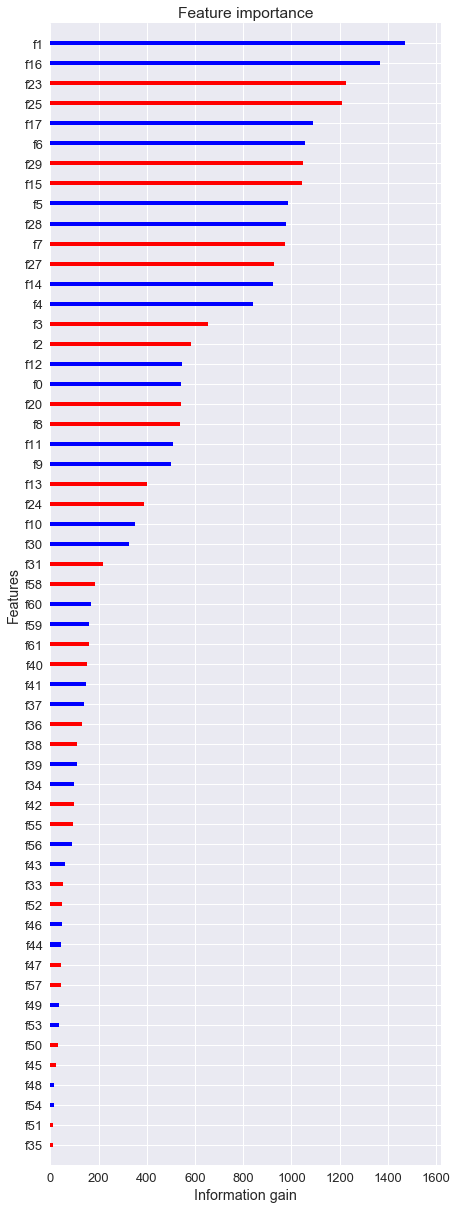

In [87]:
# The number of times a feature is used to split the data across all trees

sns.set(font_scale = 1.3)
plt.rcParams['figure.figsize'] = (7.0, 21.0)
importance = xgb.plot_importance(bst, title = 'Feature importance', 
                                 color=['r', 'r', 'b', 'b'], xlabel = 'Information gain', 
                                 ylabel='Features', importance_type = 'weight', show_values = False)

In [ ]:
xgb_preds = (bst.predict(d_valid) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_preds == y_val) / len(y_val)
print("Xgb accuracy: %0.3f" % xgb_accuracy)

In [44]:
# Normalizing test feature values

X_test = df_test.iloc[:, 3:]
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).values
X_test = scaler.fit_transform(X_test)
X_test = np.hstack((X_test, vec_stack_test))

In [48]:
# Predicting the labels using test data

d_test = xgb.DMatrix(X_test)
p_test = (bst.predict(d_test) >= 0.5).astype(int)

In [57]:
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub = sub.loc[sub['is_duplicate'] == 1]

In [58]:
sub.to_csv("data/submission.csv", index=False)